In [1]:
from scipy.special import factorial, gamma
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import numpy as np
import powerlaw
import random
import heapq
import math

In [2]:
n = 10000
m = int(2*n)

def GNM(n, m):
    forbiddenEdges = defaultdict(set)
    rangeSet = set(range(n))    
    edges = []
    for _ in range(m):
        i = random.randrange(n)
        j = random.choice(tuple(
            rangeSet.difference(forbiddenEdges[i].union({i}))
        ))
        forbiddenEdges[i].add(j)
        forbiddenEdges[j].add(i)
        edges.append((i,j))    
    g = ig.Graph(n) 
    g.add_edges(edges)
    return g

start = time()
g = GNM(n, m)
print(f"n:{n}, m: {m}, time: {round(time()-start, 4)} s")
#g.save(f"GNM/GNMn{n}m{m}.net")
#ig.plot(g, f"GNM/GNMn{n}m{m}.png")

for n in (50, 100, 1000):
    for i in range(1, 6):        
        #GNM(n, n*i).save(f"GNM/GNMn{n}m{n*i}.net")
        pass

n:10000, m: 20000, time: 10.7456 s


In [3]:
n = 10000
p = 0.1

def GNP(n, p):       
    possibleEdges = combinations(range(n), 2)
    r = random.random    
    g = ig.Graph(n)
    g.add_edges(edge for edge in possibleEdges if r() < p)
    return g

start = time()
g = GNP(n, p)
print(f"n:{n}, p: {p}, time: {round(time()-start, 4)} s")
#g.save(f"GNP/GNPn{n}p{str(p).replace('.', '_')}.net")
#ig.plot(g, f"GNP/GNPn{n}p{str(p).replace('.', '_')}.png")

for n in (50, 100, 1000):
    for p in (0.0, 0.1, 0.2, 0.5, 0.9, 1.0):        
        #GNP(n, p).save(f"GNP/GNPn{n}p{str(p).replace('.', '_')}.net")
        pass

n:10000, p: 0.1, time: 21.2432 s


In [4]:
n = 10000
p = 0.75

def WS(n, p):
    g = ig.Graph(n)
    sources = list(range(n))
    forbiddenEdges = {i: {i} for i in sources}
    for i in (1, 2):
        targets = sources[i:] + sources[0:i]
        g.add_edges(list(zip(sources, targets)))
        for source, target in zip(sources, targets):
            forbiddenEdges[source].add(target)
            forbiddenEdges[target].add(source)
    sources = set(sources)
    toDelete = []
    toAdd = []
    for i, old_j in g.get_edgelist():
        if random.random() < p:
            forbiddenEdges[i].remove(old_j)
            forbiddenEdges[old_j].remove(i)
            toDelete.append((i, old_j))
            
            new_j = random.choice(tuple(
                sources.difference(forbiddenEdges[i])
            ))
            forbiddenEdges[i].add(new_j)
            forbiddenEdges[new_j].add(i)
            toAdd.append((i, new_j))            

    g.delete_edges(toDelete)
    g.add_edges(toAdd)
    return g

start = time()
g = WS(n, p)
print(f"n:{n}, p: {p}, time: {round(time()-start, 4)} s")
#g.save(f"WS/WSn{n}p{str(p).replace('.', '_')}.net")
#ig.plot(g, f"WS/WSn{n}p{str(p).replace('.', '_')}.png")

for n in (50, 100, 1000):
    for p in (0.0, 0.1, 0.2, 0.5, 0.9, 1.0):        
        #WS(n, p).save(f"WS/WSn{n}p{str(p).replace('.', '_')}.net")
        pass

n:10000, p: 0.75, time: 9.2005 s


In [16]:
n = 10000
m0 = 5
m = 5

def BA(n, m, m0):
    vertices = list(range(m0))
    forbiddenEdges = set()
    degrees = [m0-1] * m0    
    edges = []    
    for index in range(m0, n):
        forbiddenEdges.clear()      
        count = 0
        while count < m:
            target = random.choices(vertices, degrees)[0]
            if target not in forbiddenEdges:
                edges.append((index, target))
                forbiddenEdges.add(target)
                degrees[target] += 1                
                count += 1
        vertices.append(index)
        degrees.append(m)
    
    g = ig.Graph.Full(n=m0)
    g.add_vertices(n-m0)
    g.add_edges(edges)
    return g

start = time()
g = BA(n, m, m0)
print(f"n:{n}, m: {m}, m0: {m0}, time: {round(time()-start, 4)} s")
#g.save(f"BA/BAn{n}m{m}M{m0}.net")
#ig.plot(g, f"BA/BAn{n}m{m}M{m0}.png")

m0 = 5
for n in (50, 100, 1000):
    for m in (1, 2, 5):
        #BA(n, m, m0).save(f"BA/BAn{n}m{m}M{m0}.net")
        pass

n:10000, m: 5, m0: 5, time: 33.0029 s


In [6]:
n = 10000
distributions = {
    "gamma": lambda n: np.random.gamma(5, 1, size=n).astype(int),
    "poisson": lambda n: np.random.poisson(5, n)
}

def CM(n, distribution):    
    forbiddenEdges = defaultdict(set)
    g = ig.Graph(n)
    edges = []
    
    degrees = [1]
    while sum(degrees) % 2 != 0:
        degrees = distribution(n)    
    stubs = {i: degree for i, degree in enumerate(degrees) if degree>0}
    heap = [(-degree, i) for i, degree in stubs.items()]    
    rangeSet = set(stubs.keys()) 
    heapq.heapify(heap)    
    
    while stubs:     
        source = None
        while source not in stubs:
            v, source = heapq.heappop(heap)
        targets = rangeSet.difference(forbiddenEdges[source].union({source}))
        target = random.choice(tuple(targets))        
        
        forbiddenEdges[source].add(target)
        forbiddenEdges[target].add(source)
        edges.append((source, target))

        for idx in (source, target):
            stubs[idx] -= 1
            if stubs[idx] == 0:
                rangeSet.remove(idx)
                del stubs[idx]
        
        if source in stubs:
            heapq.heappush(heap, (-stubs[source], source))
        
    g.add_edges(edges)
    return g

start = time()
g = CM(n, distributions["gamma"])
print(f"n:{n}, time: {round(time()-start, 4)} s")
#g.save(f"CM/CMn{n}gamma.net")
#ig.plot(g, f"CM/CMn{n}{name}.png")
for n in (50, 100, 1000):
    for name, distribution in distributions.items():
        #CM(n, distribution).save(f"CM/CMn{n}{name}.net")
        pass

n:10000, time: 18.6481 s


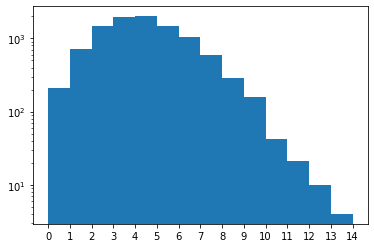

In [2]:
g = ig.load("GNM/GNMn10000m20000.net")
x = g.degree()
maxX = max(x)

fig, ax = plt.subplots()
plt.xticks(range(maxX+1))
ax.hist(x, bins=maxX)
ax.set_yscale('log')
plt.show()

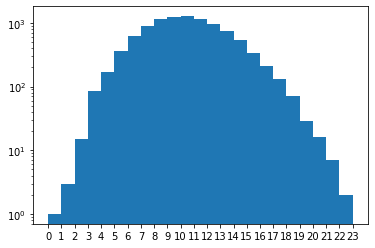

In [3]:
g = ig.load("GNP/GNPn10000p0_001.net")
x = g.degree()
maxX = max(x)

fig, ax = plt.subplots()
plt.xticks(range(maxX+1))
ax.hist(x, bins=maxX)
ax.set_yscale('log')
plt.show()

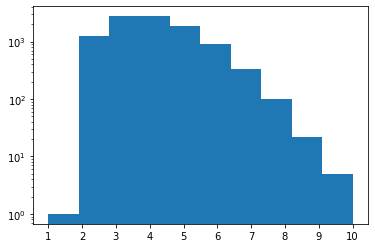

In [4]:
g = ig.load("WS/WSn10000p0_75.net")
x = g.degree()
maxX = max(x)

fig, ax = plt.subplots()
plt.xticks(range(maxX+1))
ax.hist(x, bins=maxX)
ax.set_yscale('log')
plt.show()

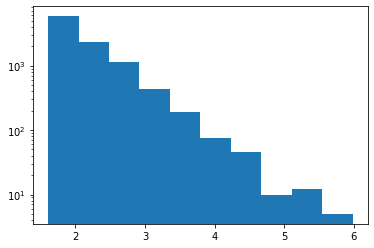

In [5]:
g = ig.load("BA/BAn10000m5M5.net")
x = np.log(g.degree())

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.hist(x)
plt.show()

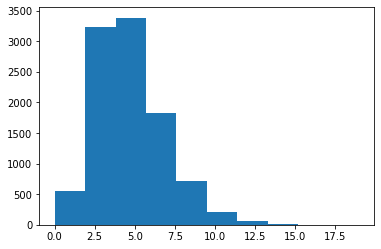

In [6]:
g = ig.load("CM/CMn10000gamma.net")
fig, ax = plt.subplots()
ax.hist(g.degree())
plt.show()

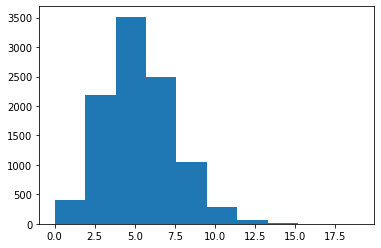

In [7]:
g = ig.load("CM/CMn10000poisson.net")
fig, ax = plt.subplots()
ax.hist(g.degree())
plt.show()

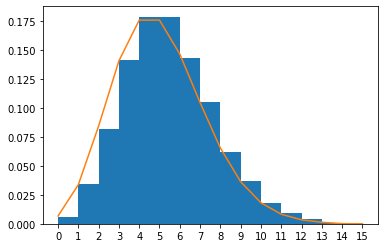

In [8]:
fig, ax = plt.subplots()
k = 5
n = 10000
s = np.random.poisson(k, n)
maxS = max(s)
plt.hist(s, bins=maxS, density=True)

t = range(maxS+1)
d = np.exp(-k)*np.power(k, t)/factorial(t)
plt.plot(d)

plt.xticks(t)
plt.show()

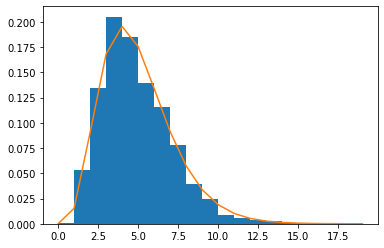

In [9]:
shape = 5
scale = 1
n = 1000
s = np.random.gamma(shape, scale, size=n).astype(int)
sMax = max(s)

fig, ax = plt.subplots()
count, bins, ignored = plt.hist(s, sMax, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) / (gamma(shape)*scale**shape))
ax.plot(bins, y)
plt.show()

Calculating best minimal value for power law fit
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Should be: 3 0
Is: 2.9864301116017247 0.07439239231299492


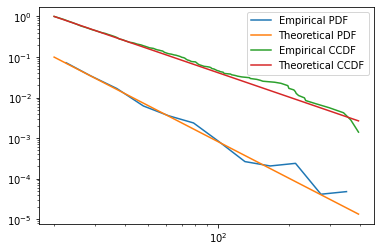

In [10]:
g = ig.load("BA/BAn10000m5M5.net")
data = g.degree()

fit = powerlaw.Fit(data)
print("Should be: 3 0")
print("Is:", fit.power_law.alpha, fit.power_law.sigma)

figCCDF = fit.plot_pdf(label="Empirical PDF")
fit.power_law.plot_pdf(ax=figCCDF, label="Theoretical PDF")

fit.plot_ccdf(ax=figCCDF, label="Empirical CCDF")
fit.power_law.plot_ccdf(ax=figCCDF, label="Theoretical CCDF")

plt.legend()
plt.show()

In [11]:
g = ig.load("BA/BAn10000m5M5.net")
ks = g.degree()
denominator = min(ks) - 1/2
y = 1 + n/sum(math.log(k/denominator) for k in ks)
print(y)

1.174613458745331
